In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [ ]:
#Data stuff happens here
time_res = 2000
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76]

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)

data = np.array([hares_fine, lynxes_fine]).T
data_orig = data.copy()
data_test = data[:100]
data = data[100:]
t_fine_orig = t_fine

t_fine_test = t_fine[:100]
t_fine = t_fine[100:]
data_norm = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

<ipython-input-64-f4aceb10ef9a>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


In [ ]:
# Batching
batch_size = 100 #19 batches
num_batches = len(data) // batch_size
batched_data = data.reshape(num_batches, batch_size, 2)
batched_data_test = data_test.reshape(-1, batch_size, 2)

t_batches = t_fine.reshape(num_batches, batch_size)
t_batches_test = t_fine_test.reshape(-1, batch_size)

In [ ]:
class LVParamLearner(nn.Module):
    def __init__(self):
      super().__init__()
      self.net_a = nn.Sequential(
            nn.Linear(2*batch_size, 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_b = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_g = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_d = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.sigm = lambda z:nn.functional.softplus(z)

    def forward(self, x):
      x = torch.flatten(torch.tensor(x,dtype=torch.float32))
      a = self.net_a(x)
      b = self.net_b(x)
      g = self.net_g(x)
      d = self.net_d(x)
      return self.sigm(a),self.sigm(b),self.sigm(g),self.sigm(d)

In [ ]:
paramlearner = LVParamLearner()
optimizer = torch.optim.Adam(paramlearner.parameters(), lr=5e-4)
def make_deltas(alpha, beta, gamma, delta):
    def dynamics(t, y):
        return torch.stack([
            alpha * y[0] - beta * y[0] * y[1],
            delta * y[0] * y[1] - gamma * y[1]
        ])
    return dynamics

In [ ]:
y0 = data[0]
y0 = torch.tensor(y0)
print(y0)
t_fine = torch.tensor(t_fine)
pred = 0
for epoch in range(250):
  for data_batch,time_batch in zip(batched_data,t_batches):
    optimizer.zero_grad()
    y0 = data_batch[0]
    y0 = torch.tensor(y0)
    time_batch = torch.tensor(time_batch)
    params = paramlearner(data_batch)

    alp,bet,gam,delt = params
    alp,bet,gam,delt = alp.squeeze(),bet.squeeze(),gam.squeeze(),delt.squeeze()
    print(alp,bet,gam,delt)
    dynamics = make_deltas(alp,bet,gam,delt)

    pred = odeint(dynamics,y0,time_batch,method='dopri5')

    target = torch.tensor(data_batch)
    loss = torch.mean(((pred - target)**2))


    if torch.isnan(loss):
      print("Loss became NaN — printing parameters")
      print(alp,bet,gam,delt)
      break
    loss.backward()
    optimizer.step()

  print(f"EPoch: {epoch} and Loss:{loss}")



In [ ]:
alpha,beta,gamma,delta = paramlearner(batched_data[-1])
alpha,beta,gamma,delta = alpha.squeeze(),beta.squeeze(),gamma.squeeze(),delta.squeeze()
dynamics = make_deltas(alpha,beta,gamma,delta)

new_y0 = data_test[0]
new_y0 = torch.tensor(new_y0)
t_fine_test = torch.tensor(t_fine_test)
pred = odeint(dynamics,new_y0,t_fine_test,method='dopri5')

test_loss = torch.mean(((pred - torch.tensor(data_test))**2))
print(test_loss)
print(pred)
print(data_test)

tensor(1195.1615, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor([[19.5800, 30.0900],
        [19.6909, 29.1050],
        [19.8128, 28.1542],
        [19.9454, 27.2366],
        [20.0887, 26.3509],
        [20.2425, 25.4964],
        [20.4067, 24.6718],
        [20.5811, 23.8763],
        [20.7658, 23.1089],
        [20.9607, 22.3686],
        [21.1657, 21.6547],
        [21.3807, 20.9661],
        [21.6058, 20.3021],
        [21.8409, 19.6617],
        [22.0861, 19.0443],
        [22.3413, 18.4489],
        [22.6066, 17.8750],
        [22.8819, 17.3216],
        [23.1674, 16.7882],
        [23.4631, 16.2739],
        [23.7690, 15.7783],
        [24.0851, 15.3005],
        [24.4117, 14.8400],
        [24.7487, 14.3962],
        [25.0962, 13.9685],
        [25.4544, 13.5563],
        [25.8233, 13.1591],
        [26.2031, 12.7764],
        [26.5938, 12.4076],
        [26.9956, 12.0523],
        [27.4086, 11.7100],
        [27.8330, 11.3802],
        [28.2689, 11.0625],
        [28.

In [ ]:
preds = odeint(dynamics,torch.tensor(data_orig[0]),torch.tensor(t_fine_orig),method='dopri5')


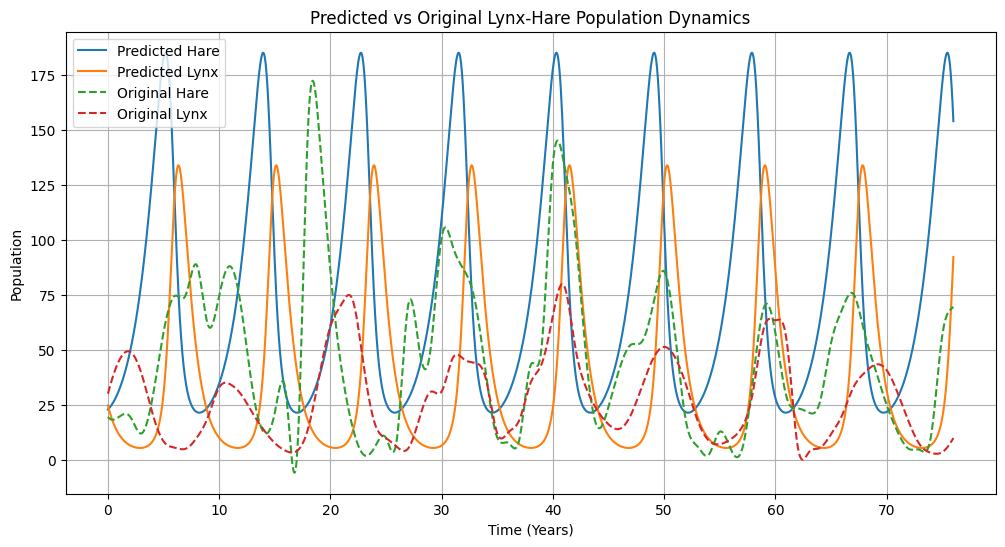

In [ ]:
# prompt: Just plot preds with t_fine_orig and data_orig with t_fine_orig

import matplotlib.pyplot as plt

# Ensure preds is a numpy array for plotting
preds_np = preds.detach().numpy()

plt.figure(figsize=(12, 6))
plt.plot(t_fine_orig, preds_np[:, 0], label='Predicted Hare')
plt.plot(t_fine_orig, preds_np[:, 1], label='Predicted Lynx')
plt.plot(t_fine_orig, data_orig[:, 0], label='Original Hare', linestyle='dashed')
plt.plot(t_fine_orig, data_orig[:, 1], label='Original Lynx', linestyle='dashed')
plt.xlabel('Time (Years)')
plt.ylabel('Population')
plt.title('Predicted vs Original Lynx-Hare Population Dynamics')
plt.legend()
plt.grid(True)
plt.show()

# Compared to traditional Optimization + Residual error learning

In [ ]:
#Data stuff happens here
time_res = 2000
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)

data = np.array([hares_fine, lynxes_fine]).T

data_test = data[:100]
data_train = data[100:]

t_fine_test = t_fine[:100]
t_fine_train = t_fine[100:]

<ipython-input-3-3829284712>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# prompt: with the above data, make a simple parameter learner that learns the four parameters of the LV model

class LV(nn.Module):

    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1))
        self.b = nn.Parameter(torch.tensor(0.01))
        self.g = nn.Parameter(torch.tensor(0.4))
        self.d = nn.Parameter(torch.tensor(0.005))

    def forward(self, t, y):
        # y = [H, L]
        H = y[0]
        L = y[1]
        dHdt = self.a * H - self.b * H * L
        dLdt = self.d * H * L - self.g * L
        return torch.stack([dHdt, dLdt])

# Convert data to tensor and normalize
data_tensor = torch.tensor(data_train, dtype=torch.float32,device=device)

# Create the model
model = LV()
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Integrate the ODE
    pred_y = odeint(model, data_tensor[0], torch.tensor(t_fine_train, dtype=torch.float32),method='dopri5')

    # Calculate loss (Mean Squared Error)
    loss = torch.mean((pred_y - data_tensor)**2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




In [ ]:
print("\nLearned Parameters:")
print(f"a: {model.a.item():.4f}")
print(f"b: {model.b.item():.4f}")
print(f"c: {model.g.item():.4f}")
print(f"d: {model.d.item():.4f}")


Learned Parameters:
a: 0.2385
b: 0.0094
c: 0.3052
d: 0.0076


In [ ]:
alpha = 0.2385
beta = 0.0094
gamma = 0.3052
delta = 0.0076

def dynamics(t, y):
    return torch.stack([
        alpha * y[0] - beta * y[0] * y[1],
        delta * y[0] * y[1] - gamma * y[1]
    ])

The graph is noticeably fitting the data much less

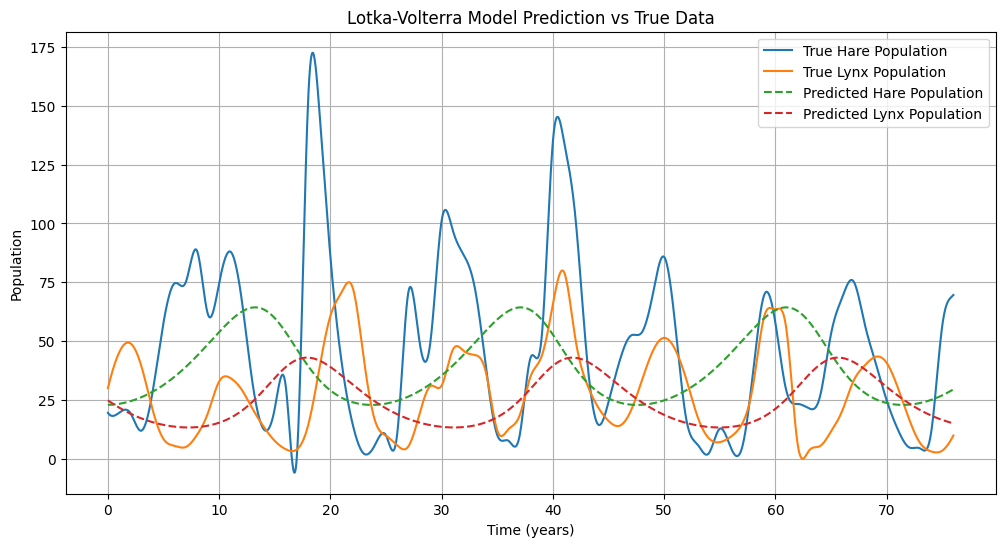

In [ ]:
# prompt: Graph the results against true data

import numpy as np
import matplotlib.pyplot as plt

# Predict the solution using the trained model
with torch.no_grad():
    predicted_data_norm = odeint(dynamics, data_tensor[0], torch.tensor(t_fine, dtype=torch.float32)).numpy()

# Denormalize the predicted data
predicted_data = predicted_data_norm

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(t_fine, hares_fine, label='True Hare Population')
plt.plot(t_fine, lynxes_fine, label='True Lynx Population')
plt.plot(t_fine, predicted_data[:, 0], linestyle='--', label='Predicted Hare Population')
plt.plot(t_fine, predicted_data[:, 1], linestyle='--', label='Predicted Lynx Population')

plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Prediction vs True Data')
plt.legend()
plt.grid(True)
plt.show()

## Attempting to capture error or residuals between the model and real data

In [ ]:
batch_size_train = 100
batches_train = []
t_fine_batches_train = []

# Create batches for training data
for i in range(0, len(data_train), batch_size_train):
    batch_data = data_train[i:i + batch_size_train]
    batch_t = t_fine_train[i:i + batch_size_train]
    batches_train.append(torch.tensor(batch_data, dtype=torch.float32, device=device))
    t_fine_batches_train.append(torch.tensor(batch_t, dtype=torch.float32, device=device))

# Data test is used as a single batch
batch_size_test = len(data_test)
batches_test = [torch.tensor(data_test, dtype=torch.float32, device=device)]
t_fine_batches_test = [torch.tensor(t_fine_test, dtype=torch.float32, device=device)]

print(f"Number of training batches: {len(batches_train)}")
print(f"Number of test batches: {len(batches_test)}")
print(f"Size of the first training batch: {batches_train[0].shape}")
print(f"Size of the test batch: {batches_test[0].shape}")


Number of training batches: 19
Number of test batches: 1
Size of the first training batch: torch.Size([100, 2])
Size of the test batch: torch.Size([100, 2])


In [ ]:
class ModdedLV(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)
      self.f = nn.Sequential(
          nn.Linear(batch_size_train, 8),
          nn.SiLU(),
          nn.Linear(8,64),
          nn.SiLU(),
          nn.Linear(64, 8),
          nn.SiLU(),
          nn.Linear(8, batch_size_train),
          nn.Sigmoid()
      )
      self.g = nn.Sequential(
          nn.Linear(batch_size_train, 8),
          nn.SiLU(),
          nn.Linear(8,64),
          nn.SiLU(),
          nn.Linear(64, 8),
          nn.SiLU(),
          nn.Linear(8, batch_size_train),
          nn.Sigmoid()
      )

  def forward(self, y):
      return self.f(y),self.g(y)
moddedlv = ModdedLV()
moddedlv.to(device)
optimizer = torch.optim.Adam(moddedlv.parameters(), lr=0.005)
data_tensor = torch.tensor(data_train, dtype=torch.float32,device=device)


In [ ]:

for epoch in range(500):
    optimizer.zero_grad()
    # dymaics = make_deltas(alpha, beta, gamma, delta)
    for batch_data, batch_t in zip(batches_train, t_fine_batches_train):
        pred_y = odeint(dynamics, batch_data[0], batch_t,method='dopri5')
        residualf,residualg = moddedlv(batch_t)
        residual = torch.tensor(batch_data, dtype=torch.float32, device=device)
        residual[:,0] = residualf
        residual[:,1] = residualg
        pred = pred_y + residual
        loss = torch.mean((pred - batch_data)**2)
        loss.backward()
        optimizer.step()


    print(f"{epoch} and Loss : {loss}")


When f and g are used as source terms inside the model, they can often turn the model stiff, which is undesireable. Thats why f and g have been trained as learning the residual or error of the model with real data in order to shift the model in the correct direction

In [ ]:
pred_y = odeint(dynamics, batch_data[0], batch_t[0:batch_size_train],method='dopri5')
residualf,residualg = moddedlv(batch_t[0:batch_size_train])
residual = torch.tensor(batch_data[0:batch_size_train], dtype=torch.float32, device=device)
residual[:,0] = residualf
residual[:,1] = residualg
pred = pred_y + residual





<ipython-input-58-3930790565>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  residual = torch.tensor(batch_data[0:batch_size_train], dtype=torch.float32, device=device)


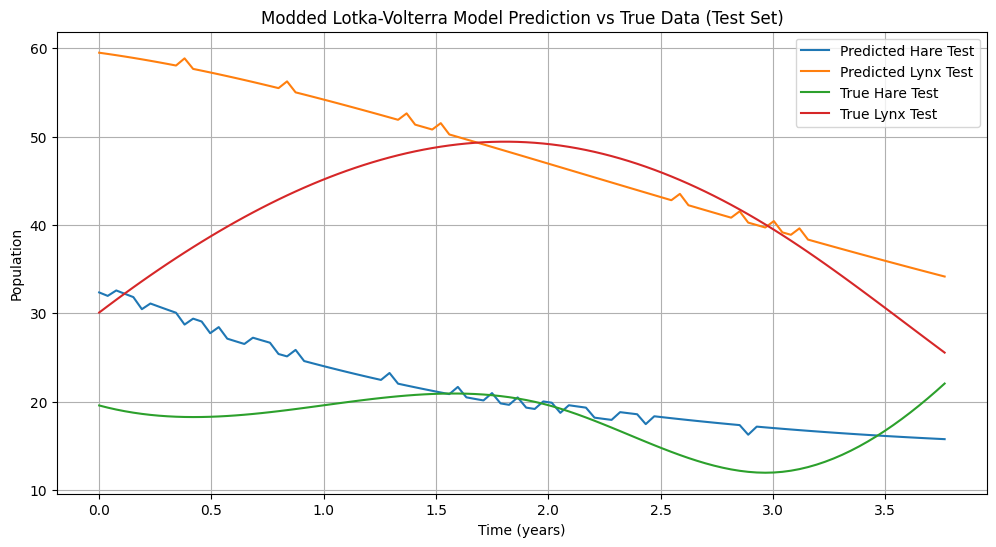

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(t_fine_test, pred.cpu().detach().numpy()[:, 0], label='Predicted Hare Test')
plt.plot(t_fine_test, pred.cpu().detach().numpy()[:, 1], label='Predicted Lynx Test')
plt.plot(t_fine_test, data_test[:, 0], label='True Hare Test')
plt.plot(t_fine_test, data_test[:, 1], label='True Lynx Test')
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.title('Modded Lotka-Volterra Model Prediction vs True Data (Test Set)')
plt.legend()
plt.grid(True)
plt.show()


As visible, the residuals being captured introduce non-smooth points to an otherwise smooth solution. Smoothness is desireable inorder to apply classical mathematical theory and capturing residuals like this detracts from the smoothness. What is required is a smooth but accurate solution.